# ASI assessed exercise 2016/2017 (Work in Progress)
5th May 2017

## Introduction and Instructions

In this work you will analyze the MNIST and CIFAR10 datasets available to download from:
- http://yann.lecun.com/exdb/mnist/
- https://www.cs.toronto.edu/~kriz/cifar.html

# Exercises
Note (code) and (text) before each task indicate whether the corresponding part involves coding or writing.

1) (code) Download the MNIST and CIFAR10 datasets and import them. [3]

In [1]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
from keras.datasets import mnist, cifar10

Using TensorFlow backend.


In [2]:
(mnist_train_data, mnist_train_label), (mnist_test_data, mnist_test_label) = mnist.load_data()
(cifar_train_data, cifar_train_label), (cifar_test_data, cifar_test_label) = cifar10.load_data()

## 2) (text) Comment on the distribution of class labels and the dimensionality of the input and how these may affect the analysis. [7]

Let's see the labels distribution.

In [3]:
mnist_num_samples = len(mnist_train_data)
mnist_unique, mnist_counts = np.unique(mnist_train_label, return_counts=True)
mnist_label_prob = dict(zip(mnist_unique, mnist_counts/mnist_num_samples))
mnist_label_prob

{0: 0.098716666666666661,
 1: 0.11236666666666667,
 2: 0.099299999999999999,
 3: 0.10218333333333333,
 4: 0.097366666666666671,
 5: 0.09035,
 6: 0.098633333333333337,
 7: 0.10441666666666667,
 8: 0.097516666666666668,
 9: 0.099150000000000002}

In [4]:
cifar_num_samples = len(cifar_train_data)
cifar_unique, cifar_counts = np.unique(cifar_train_label, return_counts=True)
cifar_label_prob = dict(zip(cifar_unique, cifar_counts/cifar_num_samples))
cifar_label_prob

{0: 0.10000000000000001,
 1: 0.10000000000000001,
 2: 0.10000000000000001,
 3: 0.10000000000000001,
 4: 0.10000000000000001,
 5: 0.10000000000000001,
 6: 0.10000000000000001,
 7: 0.10000000000000001,
 8: 0.10000000000000001,
 9: 0.10000000000000001}

Defining $K$ as the number of different labels we can have in our dataset and $k = 0,1,2, ..., K-1 $, with MNIST we notice that 
$$
P(t = k) \approx \dfrac{1}{K}
$$
while with CIFAR10 we have:
$$
P(t = k) = \dfrac{1}{K}
$$
which means we can assume the prior  constant.

# Data pre-processing 

## Reshaping

Let's see the dimensionality of the input.

In [5]:
print(mnist_train_data.shape)
print(cifar_train_data.shape)

(60000, 28, 28)
(50000, 32, 32, 3)


We need to flatten each sample.

In [6]:
mnist_train_data = mnist_train_data.reshape(mnist_num_samples, -1)
cifar_train_data = cifar_train_data.reshape(cifar_num_samples, -1)

print(mnist_train_data.shape)
print(cifar_train_data.shape)


(60000, 784)
(50000, 3072)


The dimensionality of the input for CIFAR10 is very high, 3072. This means classification might be difficult and we probably need more training data to get good results. Here using PCA could be a possible improvement.

In [7]:
mnist_test_data = mnist_test_data.reshape(len(mnist_test_data), -1)
print(mnist_test_data.shape)

cifar_test_data = cifar_test_data.reshape(len(cifar_test_data), -1)
print(cifar_test_data.shape)

(10000, 784)
(10000, 3072)


## Normalizing

Working with small numbers could help avoiding overflows, so we normalize.

In [8]:
mnist_train_data_norm = mnist_train_data/255
mnist_test_data_norm = mnist_test_data/255

cifar_train_data_norm = cifar_train_data/255
cifar_test_data_norm = cifar_test_data/255


## 3) Classification
- a) (code) Implement the Naïve Bayes classifier. [10]


## Splitting the samples by label

In [62]:
# Group the data by labels
mnist_K = len(mnist_unique)
cifar_K = len(cifar_unique)
mnist_train_data_label_norm = [mnist_train_data_norm, mnist_train_label] # [1] for label, [0][6] for 7-th sample
mnist_train_splitted_labels_norm = {}

mnist_test_data_label_norm = [mnist_test_data_norm, mnist_test_label] # [1] for label, [0][6] for 7-th sample
mnist_test_splitted_labels_norm = {}

cifar_train_data_label_norm = [cifar_train_data_norm, cifar_train_label]
cifar_train_splitted_labels_norm = {}

cifar_test_data_label_norm = [cifar_test_data_norm, cifar_test_label]
cifar_test_splitted_labels_norm = {}

def split_data(data, data_label, K):
    splitted_labels = {}
    for k in range(K):
        splitted_labels[k] = []
    for i in range(len(data)):
        for k in range(K):
            if data_label[1][i] == k:
                splitted_labels[k].append(data_label[0][i]) # [7] list of all 7-labeled images
    return splitted_labels

mnist_train_splitted_labels_norm = split_data(mnist_train_data_norm, mnist_train_data_label_norm, mnist_K)
cifar_train_splitted_labels_norm = split_data(cifar_train_data_norm, cifar_train_data_label_norm, mnist_K)

mnist_test_splitted_labels_norm = split_data(mnist_test_data_norm, mnist_test_data_label_norm, mnist_K)
cifar_test_splitted_labels_norm = split_data(cifar_test_data_norm, cifar_test_data_label_norm, mnist_K)

## Defining functions for prediction

In [78]:
def get_means_vars(samples_):
    """
    given all the samples, it returns means and vars in a dictionary with label as index
    means_[k] is an array (784,)
    """
    epsilon = 1e-3
    means_, vars_ = {}, {}
    for k in range(len(samples_)): 
        tmp = np.array(samples_[k])
        means_[k] = tmp.mean(axis=0)
        vars_[k] = tmp.var(axis=0) + epsilon
    return means_, vars_
    
def likelihood(sample, means_k, vars_k):
    """
    likelihood of an image
    product of a sequence sampled from a normal
    """
    return np.prod(np.float128(np.exp(-(sample - means_k)/(2*(vars_k))) / (np.sqrt(2*np.pi*vars_k))))

def probability_k(sample, k, dataset='mnist'):
    """
    probability that a sample is k-labeled
    """
    global new_sample, prev_den # to avoid computation

    if dataset=='cifar':
        means_, vars_, K = cifar_means_, cifar_vars_, cifar_K
    else: 
        means_, vars_, K = mnist_means_, mnist_vars_, mnist_K
    LH = likelihood(sample, means_[k], vars_[k])
    num = LH*.1 
    # the denominator is just a normalization constant, we don't need it for the max
#     if new_sample == 1:
#         den = 0
#         for j in range(K):
#             den += likelihood(sample, means_[j], vars_[j])*.1
#         prev_den = den
#     else:
#         den = prev_den
#     return num/den
    return num

new_sample, prev_den = 0, 0
mnist_means_, mnist_vars_ = get_means_vars(mnist_train_splitted_labels_norm)
cifar_means_, cifar_vars_ = get_means_vars(cifar_train_splitted_labels_norm)

## Testing
Let's test the implementation on a small scale with MNIST.

In [82]:
for s in range(4):
    new_sample = 1
    sample = 0+s
    print("Sample # %d, True label: %d" % (sample, mnist_test_label[sample]))
    for k in range(10):
#         probability_k(mnist_test_data_norm[sample], k, 'mnist')
#         print("Label %d | probability %.2f" % (k, probability_k(mnist_test_data_norm[sample], k)))
        print("Label %d | probability %s" % (k, str(probability_k(mnist_test_data_norm[sample], k, 'mnist'))))
        new_sample = 0
    print()
                                             

Sample # 0, True label: 7
Label 0 | probability 5.42090412406e-310
Label 1 | probability 2.06824571165e-1413
Label 2 | probability 3.18569832295e-510
Label 3 | probability 6.0668480093e+209
Label 4 | probability 3.98154452645e+248
Label 5 | probability 5.29597170182e+293
Label 6 | probability 2.73588425003e-1339
Label 7 | probability 8.11063440359e+569
Label 8 | probability 3.1712567363e+189
Label 9 | probability 3.16712902222e+523

Sample # 1, True label: 2
Label 0 | probability 1.6607789148e-493
Label 1 | probability 1.03045985824e-2030
Label 2 | probability 7.75328551564e+363
Label 3 | probability 4.12360500291e-513
Label 4 | probability 3.13156518268e-1105
Label 5 | probability 2.71144985056e-477
Label 6 | probability 5.61558300515e-348
Label 7 | probability 8.04282394815e-3964
Label 8 | probability 8.9446810335e-903
Label 9 | probability 2.69249310039e-2669

Sample # 2, True label: 1
Label 0 | probability 1.52872241193e+482
Label 1 | probability 1.02732589851e+701
Label 2 | probab

The predicted label for each sample is the one with the highest probability, and it's seems to work.
Let's test it now with CIFAR10.

In [83]:
for s in range(10):
    new_sample = 1
    sample = 0+s
    print("Sample # %d, True label: %d" % (sample, cifar_test_label[sample]))
    for k in range(10):
    #     print("Label %d | probability %.2f" % (k, probability_k(mnist_test_data_norm[sample], k)))
        print("Label %d | probability %s" % (k, str(probability_k(cifar_test_data_norm[sample], k, 'cifar'))))
        new_sample = 0
    print()
                                             

Sample # 0, True label: 3
Label 0 | probability 6.21588755663e+2127
Label 1 | probability 9.66401780762e+736
Label 2 | probability 2.03084278545e+1219
Label 3 | probability 9.03941112207e+874
Label 4 | probability 4.68157351705e+999
Label 5 | probability 8.39786759545e+1028
Label 6 | probability 3.84946581637e+588
Label 7 | probability 1.18710590054e+1059
Label 8 | probability 1.61358103115e+1881
Label 9 | probability 1.82915254488e+1051

Sample # 1, True label: 8
Label 0 | probability 3.54650255046e+36
Label 1 | probability 1.72489154124e-755
Label 2 | probability 2.79581209936e-904
Label 3 | probability 1.24837953443e-916
Label 4 | probability 3.64214202368e-1376
Label 5 | probability 4.78868450406e-820
Label 6 | probability 2.2558717035e-1953
Label 7 | probability 9.52471457978e-494
Label 8 | probability 1.9806025678e-246
Label 9 | probability 6.18424890401e-554

Sample # 2, True label: 8
Label 0 | probability 5.94437546516e+1011
Label 1 | probability 5.83124310448e+61
Label 2 | pro

The predicted label is not correct. It is always one. We have some problems here.

Let's test on the whole MNIST test set.

In [41]:
def predict(data, labels, dataset='mnist', perc=10):
    global new_sample, prev_den 
    correct = 0
    perc = perc/100
    total = int(len(data)*perc)
    predicted_labels = np.zeros(total)
    print("Predicting %d images from %s..." % (total, dataset))
    t0 = time()
    new_sample, prev_den = 0, 0
    for sample in range(total):
        new_sample = 1
        probabilities_sample = []
        for k in range(10):
            true_label =  labels[sample]
            probabilities_sample.append(probability_k(data[sample], k, dataset))
            new_sample = 0
        predicted_label = probabilities_sample.index(max(probabilities_sample))
        predicted_labels[sample] = int(predicted_label)
        if predicted_label == true_label:
            correct += 1
            
    print("Time for %d samples: %.2f" % (total, time()-t0))
    print("Accuracy: ",(correct/total))
    return predicted_labels

    

In [84]:
mnist_predicted_labels = predict(mnist_test_data_norm, mnist_test_label, dataset='mnist',perc=100)


Predicting 10000 images from mnist...
Time for 10000 samples: 3.54
Accuracy:  0.7149


In [85]:
cifar_predicted_labels = predict(cifar_test_data_norm, cifar_test_label, 'cifar', 100)

Predicting 10000 images from cifar...
Time for 10000 samples: 8.16
Accuracy:  0.1001


- b) (text) Describe a positive and a negative feature of the classifier for these tasks [5]

Positive feature: non-parametric model and not heavy in computation.
Negative feature: too simple and does not work with datasets with high dimensionality.

- c) (text) Describe any data pre-processing that you suggest for this data and your classifier [5]
- d) (code) Apply your classifier to the two given datasets. Make sure your optimization is clearly commented. Use classification accuracy and test log-likelihood as your figures of merit [15]
- e) (code) Display the confusion matrix on the test data [5]

In [60]:
from sklearn.metrics import confusion_matrix
mnist_conf_matrix = confusion_matrix(mnist_test_label[:len(mnist_predicted_labels)], mnist_predicted_labels)

[[ 895    0    9    4    3    6   11    1   51    0]
 [   0 1000    7   10    0    6   10    0   98    4]
 [  32    5  737   40    8    2   55    4  147    2]
 [  17    9   56  634    7   11   14   14  212   36]
 [  17    1   18    5  425   17   23    6  254  216]
 [  68    5   16   51   20  247   18    4  437   26]
 [  19    3   22    1    2   12  861    0   38    0]
 [   1    7   12   17   17    0    1  677   69  227]
 [  11   15   21   15   13   22    8    5  823   41]
 [   4    6    6    9   38    1    0   23   72  850]]


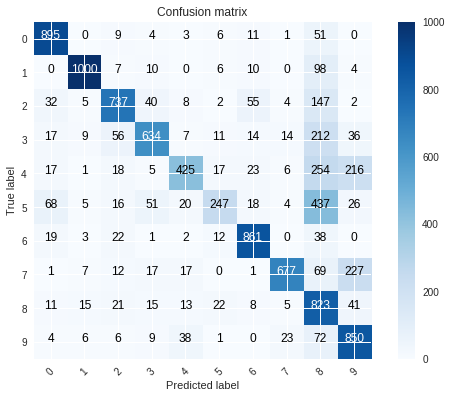

In [61]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
# Compute confusion matrix
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(mnist_conf_matrix, classes=range(10),
                      title='Confusion matrix')
plt.show()

- f) (text) Discuss the performance, compare them against a classifier that outputs
random class labels, and suggest ways in which performance could be improved [5]

4) Linear regression
- a) (code) Implement Bayesian linear regression (you should already have an
implementation from the lab sessions) [10]
- b) (code) Treat class labels as continuous and apply regression to the training data. [15]
- c) (code) Produce a scatter plot showing the predictions versus the true targets for the
test set and compute the mean squared error on the test set [5]
- d) (text) Suggest a way to discretize predictions and display the confusion matrix on the
test data and report accuracy [5]
- e) (text) Discuss regression performance with respect to classification performance [5]
- f)
(text) Describe one limitation of using regression for this particular task. [5]

5) Bonus question
- a) (text / code) The state-of-the-art in these image classification problems suggests that
convolutional layers in convolutional neural networks yield most of the improvements
compared to standard neural networks. The reason is that they are capable of
modeling spatial patterns through the hierarchical analysis of patches of images.
Propose and implement ways to exploit patch information in the Naïve Bayes
classifier or linear regression. A couple of suggestions are: (i) apply Naïve Bayes
classification to the output of convolutional layer in the LeNet architecture (ii) construct
the Naïve Bayes classifier by calculating patch-specific statistics and extend this by
stacking multiple of these.

Numbers at the end of each section are the number of marks available.
Be concise - a complete solution should be around 10 pages (including figures) and no more than 20.